The error metric for this competition is the F1 score.

There are ~5,000 customers in the test set. These are the customers you will need to recommend a vendor to. Each customer can order from multiple locations (LOC_NUM).

There are ~35,000 customers in the train set. Some of these customers have made orders at at least one out of 100 vendors.

The objective of this competition is to build a recommendation engine to predict what restaurants customers are most likely to order from, given the customer location, the restaurant, and the customer order history.

test_customers.csv -       customer id’s in the test set.
test_locations.csv -       latitude and longitude for the different locations of each customer.

train_locations.csv -      customer id’s in the train set.
train_customers.csv -      latitude and longitude for the different locations of each customer.
orders.csv -               orders that the customers train_customers.csv from made.
vendors.csv -              vendors that customers can order from.

VariableDefinitions.txt -  Variable definitions for the datasets
SampleSubmission.csv -     is an example of what your submission file should look like. The order of the rows does not matter,                              but the names of CID X LOC_NUM X VENDOR must be correct. The column "target" is your prediction. The                            submission file is large so please allow up to 30 minutes for your score to reflect.

### One of the few hacks where problem formulation was one of the key things. Also dont run this notebook on colab as ram will over shoot. Run it on local machine. I have 8gb ram still windows allocates 32 gb ram (memory from HDD or SSD) upon overshooting so you are safe to run this on local machine. Also donot just hit run all, run cells manually giving few seconds gap, if you are poor and have 8GB ram and no SSD :D

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,ExtraTreesClassifier,StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,StratifiedKFold, GroupKFold,train_test_split
import gc
import datetime
import warnings
warnings.filterwarnings("ignore")
np.random.seed(0)

# Problem Formuation

In [2]:
%%time
test_customers = pd.read_csv("test_customers.csv")
test_customers = test_customers[test_customers.duplicated('akeed_customer_id', keep='first')==False].reset_index(drop=True)
test_customers.rename(columns={'akeed_customer_id': 'customer_id'}, inplace=True)
test_locations = pd.read_csv("test_locations.csv")
vendors = pd.read_csv("vendors.csv")
SampleSubmission = pd.read_csv("SampleSubmission.csv")
test_customer_detail = pd.merge(test_locations, test_customers, on='customer_id',how='left')
test_customer_detail = test_customer_detail.add_prefix('c_')
vendors = vendors.add_prefix('v_')
test=test_customer_detail.assign(key=1).merge(vendors.assign(key=1), on='key').drop('key',axis=1)
test_customers.shape,test_locations.shape,SampleSubmission.shape,vendors.shape,test_customer_detail.shape,test.shape

Wall time: 13.1 s


((9753, 8), (16720, 5), (1672000, 2), (100, 59), (16720, 12), (1672000, 71))

In [3]:
%%time
train_customers = pd.read_csv("train_customers.csv")
train_customers = train_customers[train_customers.duplicated('akeed_customer_id', keep='first')==False].reset_index(drop=True)
train_customers.rename(columns={'akeed_customer_id': 'customer_id'}, inplace=True)
train_locations = pd.read_csv("train_locations.csv")
train_customer_detail = pd.merge(train_locations, train_customers, on='customer_id',how='left')
train_customer_detail = train_customer_detail.add_prefix('c_')
train=train_customer_detail.assign(key=1).merge(vendors.assign(key=1), on='key').drop('key',axis=1)
train_customers.shape,train_locations.shape,train_customer_detail.shape,train.shape

Wall time: 1min 1s


((34523, 8), (59503, 5), (59503, 12), (5950300, 71))

In [4]:
%%time
test["CID X LOC_NUM X VENDOR"] = test["c_customer_id"].astype(str)+' X '+test["c_location_number"].astype(str)+' X '+test["v_id"].astype(str)
train["CID X LOC_NUM X VENDOR"] = train["c_customer_id"].astype(str)+' X '+train["c_location_number"].astype(str)+' X '+train["v_id"].astype(str)

Wall time: 14.9 s


In [5]:
%%time
orders = pd.read_csv("orders.csv")
train['target'] = 0
mask = (train["CID X LOC_NUM X VENDOR"].isin(list(set(train['CID X LOC_NUM X VENDOR']).intersection(set(orders['CID X LOC_NUM X VENDOR'])))))
train['target'][mask] = 1

Wall time: 15.4 s


# Pre-Processing

In [6]:
del test_customers
del test_locations
del vendors
del test_customer_detail
del train_customers
del train_locations
del train_customer_detail
del orders
del mask
gc.collect()

20

In [7]:
test_id=test['CID X LOC_NUM X VENDOR']
train.drop(['v_is_akeed_delivering', 'v_open_close_flags','v_one_click_vendor', 'v_country_id','v_city_id', 'v_display_orders',
            'c_customer_id','CID X LOC_NUM X VENDOR','v_authentication_id','c_language','v_language','v_vendor_tag'], axis = 1,inplace=True)
test.drop(['v_is_akeed_delivering', 'v_open_close_flags','v_one_click_vendor', 'v_country_id','v_city_id', 'v_display_orders',
           'c_customer_id','CID X LOC_NUM X VENDOR','v_authentication_id','c_language','v_language','v_vendor_tag'], axis = 1,inplace=True)

In [8]:
train.shape,test.shape,SampleSubmission.shape

((5950300, 61), (1672000, 60), (1672000, 2))

In [9]:
train.head(1)

,c_location_number,c_location_type,c_latitude,c_longitude,c_gender,c_dob,c_status,c_verified,c_created_at,c_updated_at,...,v_saturday_from_time1,v_saturday_to_time1,v_saturday_from_time2,v_saturday_to_time2,v_primary_tags,v_vendor_tag_name,v_created_at,v_updated_at,v_device_type,target
0,0,NaN,1.682392,-78.789737,NaN,NaN,1.0,1.0,2019-06-17 00:33:23,2019-10-01 18:46:33,...,00:00:00,00:30:00,10:00:00,23:59:00,"{""primary_tags"":""4""}","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",2018-01-30 14:42:04,2020-04-07 15:12:43,3,0


In [10]:
train.target.value_counts()

0    5870158
1      80142
Name: target, dtype: int64

In [11]:
5870158/80142

73.24696164308352

In [12]:
80142/(80142+5870158)

0.013468564610187722

# Dealing with Object Columns

In [13]:
le = LabelEncoder()

In [14]:
train.c_location_type[pd.isnull(train.c_location_type)]  = 'NaN'
test.c_location_type[pd.isnull(test.c_location_type)]  = 'NaN'
train['c_location_type']= le.fit_transform(train['c_location_type'])
test['c_location_type']= le.transform(test['c_location_type'])

In [15]:
train.c_gender=train.c_gender.str.strip()
test.c_gender=test.c_gender.str.strip()
train.c_gender[pd.isnull(train.c_gender)]  = 'NaN'
test.c_gender[pd.isnull(test.c_gender)]  = 'NaN'
train.replace({'c_gender': {'male': 'Male', '': 'NaN','?????':'NaN'}},inplace=True)
test.replace({'c_gender': {'male': 'Male', '': 'NaN','?????':'NaN'}},inplace=True)
train['c_gender']= le.fit_transform(train['c_gender'])
test['c_gender']= le.transform(test['c_gender'])

In [16]:
train.v_vendor_category_en[pd.isnull(train.v_vendor_category_en)]  = 'NaN'
test.v_vendor_category_en[pd.isnull(test.v_vendor_category_en)]  = 'NaN'
train['v_vendor_category_en']= le.fit_transform(train['v_vendor_category_en'])
test['v_vendor_category_en']= le.transform(test['v_vendor_category_en'])
# v_vendor_category_id same thing but different value counts

In [17]:
train.v_OpeningTime[pd.isnull(train.v_OpeningTime)]  = 'NaN'
test.v_OpeningTime[pd.isnull(test.v_OpeningTime)]  = 'NaN'
train['v_OpeningTime']= le.fit_transform(train['v_OpeningTime'])
test['v_OpeningTime']= le.transform(test['v_OpeningTime'])
# more feat can be extracted

In [18]:
train.v_OpeningTime2[pd.isnull(train.v_OpeningTime2)]  = 'NaN'
test.v_OpeningTime2[pd.isnull(test.v_OpeningTime2)]  = 'NaN'
train.replace({'v_OpeningTime2': {'-': 'NaN'}},inplace=True)
test.replace({'v_OpeningTime2': {'-': 'NaN'}},inplace=True)
train['v_OpeningTime2']= le.fit_transform(train['v_OpeningTime2'])
test['v_OpeningTime2']= le.transform(test['v_OpeningTime2'])
# more feat can be extracted

In [19]:
%%time
for col in ['v_sunday_from_time1', 'v_sunday_to_time1', 'v_sunday_from_time2',
       'v_sunday_to_time2', 'v_monday_from_time1', 'v_monday_to_time1',
       'v_monday_from_time2', 'v_monday_to_time2', 'v_tuesday_from_time1',
       'v_tuesday_to_time1', 'v_tuesday_from_time2', 'v_tuesday_to_time2',
       'v_wednesday_from_time1', 'v_wednesday_to_time1',
       'v_wednesday_from_time2', 'v_wednesday_to_time2',
       'v_thursday_from_time1', 'v_thursday_to_time1', 'v_thursday_from_time2',
       'v_thursday_to_time2', 'v_friday_from_time1', 'v_friday_to_time1',
       'v_friday_from_time2', 'v_friday_to_time2', 'v_saturday_from_time1',
       'v_saturday_to_time1', 'v_saturday_from_time2', 'v_saturday_to_time2']:
    train[col][pd.isnull(train[col])]  = 'NaN'
    test[col][pd.isnull(test[col])]  = 'NaN'
    train[col]= le.fit_transform(train[col])
    test[col]= le.transform(test[col])

# more feat can be extracted

Wall time: 1min 40s


In [20]:
train.v_primary_tags[pd.isnull(train.v_primary_tags)]  = 'NaN'
test.v_primary_tags[pd.isnull(test.v_primary_tags)]  = 'NaN'
train['v_primary_tags']= le.fit_transform(train['v_primary_tags'])
test['v_primary_tags']= le.transform(test['v_primary_tags'])

In [21]:
train.v_vendor_tag_name[pd.isnull(train.v_vendor_tag_name)]  = 'NaN'
test.v_vendor_tag_name[pd.isnull(test.v_vendor_tag_name)]  = 'NaN'
train['v_vendor_tag_name']= le.fit_transform(train['v_vendor_tag_name'])
test['v_vendor_tag_name']= le.transform(test['v_vendor_tag_name'])

# more feat can be extracted

In [22]:
train['c_created_at'] = pd.to_datetime(train['c_created_at'], yearfirst=True)
test['c_created_at'] = pd.to_datetime(test['c_created_at'], yearfirst=True)
train['c_updated_at'] = pd.to_datetime(train['c_updated_at'], yearfirst=True)
test['c_updated_at'] = pd.to_datetime(test['c_updated_at'], yearfirst=True)
train['v_created_at'] = pd.to_datetime(train['v_created_at'], yearfirst=True)
test['v_created_at'] = pd.to_datetime(test['v_created_at'], yearfirst=True)
train['v_updated_at'] = pd.to_datetime(train['v_updated_at'], yearfirst=True)
test['v_updated_at'] = pd.to_datetime(test['v_updated_at'], yearfirst=True)

In [23]:
%%time

def timediff(duration):
    duration_in_s = duration.total_seconds()
    days = divmod(duration_in_s, 86400)[0]
    return days

train['c_diff_update_create']=train['c_updated_at']-train['c_created_at']
train['v_diff_update_create']=train['v_updated_at']-train['v_created_at']
train['c_v_diff_create']=train['v_created_at']-train['c_created_at']
train['c_v_diff_update']=train['v_updated_at']-train['c_updated_at']

train['c_diff_update_create']=train['c_diff_update_create'].apply(timediff)
train['v_diff_update_create']=train['v_diff_update_create'].apply(timediff)
train['c_v_diff_create']=train['c_v_diff_create'].apply(timediff)
train['c_v_diff_update']=train['c_v_diff_update'].apply(timediff)

Wall time: 4min 20s


In [24]:
%%time
test['c_diff_update_create']=test['c_updated_at']-test['c_created_at']
test['v_diff_update_create']=test['v_updated_at']-test['v_created_at']
test['c_v_diff_create']=test['v_created_at']-test['c_created_at']
test['c_v_diff_update']=test['v_updated_at']-test['c_updated_at']

test['c_diff_update_create']=test['c_diff_update_create'].apply(timediff)
test['v_diff_update_create']=test['v_diff_update_create'].apply(timediff)
test['c_v_diff_create']=test['c_v_diff_create'].apply(timediff)
test['c_v_diff_update']=test['c_v_diff_update'].apply(timediff)

Wall time: 1min 12s


In [25]:
train['year_c_created_at'] = train['c_created_at'].dt.year
train['month_c_created_at'] = train['c_created_at'].dt.month
train['doy_c_created_at'] = train['c_created_at'].dt.dayofyear

train['year_c_updated_at'] = train['c_updated_at'].dt.year
train['month_c_updated_at'] = train['c_updated_at'].dt.month
train['doy_c_updated_at'] = train['c_updated_at'].dt.dayofyear

train['year_v_created_at'] = train['v_created_at'].dt.year
train['month_v_created_at'] = train['v_created_at'].dt.month
train['doy_v_created_at'] = train['v_created_at'].dt.dayofyear

train['year_v_updated_at'] = train['v_updated_at'].dt.year
train['month_v_updated_at'] = train['v_updated_at'].dt.month
train['doy_v_updated_at'] = train['v_updated_at'].dt.dayofyear

test['year_c_created_at'] = test['c_created_at'].dt.year
test['month_c_created_at'] = test['c_created_at'].dt.month
test['doy_c_created_at'] = test['c_created_at'].dt.dayofyear

test['year_c_updated_at'] = test['c_updated_at'].dt.year
test['month_c_updated_at'] = test['c_updated_at'].dt.month
test['doy_c_updated_at'] = test['c_updated_at'].dt.dayofyear

test['year_v_created_at'] = test['v_created_at'].dt.year
test['month_v_created_at'] = test['v_created_at'].dt.month
test['doy_v_created_at'] = test['v_created_at'].dt.dayofyear

test['year_v_updated_at'] = test['v_updated_at'].dt.year
test['month_v_updated_at'] = test['v_updated_at'].dt.month
test['doy_v_updated_at'] = test['v_updated_at'].dt.dayofyear

In [26]:
# train.drop(['c_created_at','c_updated_at','v_created_at','v_updated_at'], axis = 1,inplace=True)
# test.drop(['c_created_at','c_updated_at','v_created_at','v_updated_at'], axis = 1,inplace=True)

del train['c_created_at']
del train['c_updated_at']
del train['v_created_at']
del train['v_updated_at']

del test['c_created_at']
del test['c_updated_at']
del test['v_created_at']
del test['v_updated_at']

In [27]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [28]:
train['center_latitude'] = (train['c_latitude'].values + train['v_latitude'].values) / 2
train['center_longitude'] = (train['c_longitude'].values + train['v_longitude'].values) / 2
train['harvesine_dist']=haversine_array(train['c_latitude'], train['c_longitude'], train['v_latitude'], train['v_longitude'])
train['manhattan_dist']=dummy_manhattan_distance(train['c_latitude'], train['c_longitude'], train['v_latitude'], train['v_longitude'])
train['bearing']=bearing_array(train['c_latitude'], train['c_longitude'], train['v_latitude'], train['v_longitude'])

In [29]:
test['center_latitude'] = (test['c_latitude'].values + test['v_latitude'].values) / 2
test['center_longitude'] = (test['c_longitude'].values + test['v_longitude'].values) / 2
test['harvesine_dist']=haversine_array(test['c_latitude'], test['c_longitude'], test['v_latitude'], test['v_longitude'])
test['manhattan_dist']=dummy_manhattan_distance(test['c_latitude'], test['c_longitude'], test['v_latitude'], test['v_longitude'])
test['bearing']=bearing_array(test['c_latitude'], test['c_longitude'], test['v_latitude'], test['v_longitude'])

In [30]:
y=train['target']
del train['target']

In [31]:
train.shape,test.shape,y.shape

((5950300, 77), (1672000, 77), (5950300,))

# Model Training on Validation Data

In [32]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.20, random_state=18121995, stratify=y)

In [33]:
%%time
# F1 Score:  0.2401
m = LGBMClassifier(n_estimators=3000,objective= "binary",metric= "auc",learning_rate=0.1,random_state=18121995,
                    scale_pos_weight=7.3,bagging_fraction=0.8,bagging_freq=1,feature_fraction=0.8, n_jobs=-1)
m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],early_stopping_rounds=50,verbose=100)
pred=m.predict(X_test)
print('F1 Score: ',f1_score(y_test, pred))

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.907736	valid_1's auc: 0.904991
[200]	training's auc: 0.915675	valid_1's auc: 0.909949
[300]	training's auc: 0.921146	valid_1's auc: 0.912406
[400]	training's auc: 0.9243	valid_1's auc: 0.913356
[500]	training's auc: 0.927918	valid_1's auc: 0.914229
[600]	training's auc: 0.931122	valid_1's auc: 0.914746
[700]	training's auc: 0.933949	valid_1's auc: 0.915166
[800]	training's auc: 0.936643	valid_1's auc: 0.915435
[900]	training's auc: 0.938972	valid_1's auc: 0.915657
[1000]	training's auc: 0.94134	valid_1's auc: 0.915885
[1100]	training's auc: 0.943521	valid_1's auc: 0.91608
[1200]	training's auc: 0.94554	valid_1's auc: 0.916238
[1300]	training's auc: 0.947454	valid_1's auc: 0.916384
Early stopping, best iteration is:
[1338]	training's auc: 0.948109	valid_1's auc: 0.916445
F1 Score:  0.24012905614471214
Wall time: 45min 10s


In [34]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1174032
           1       0.21      0.28      0.24     16028

    accuracy                           0.98   1190060
   macro avg       0.60      0.63      0.61   1190060
weighted avg       0.98      0.98      0.98   1190060



# Model 1 Training on Complete Data 

In [35]:
%%time
m = LGBMClassifier(n_estimators=1338,objective= "binary",metric= "auc",learning_rate=0.1,random_state=18121995,
                    scale_pos_weight=7.3,bagging_fraction=0.8,bagging_freq=1,feature_fraction=0.8, n_jobs=-1)
m.fit(train, y)
full_pred=m.predict(test)

Wall time: 23min 50s


In [36]:
final=pd.DataFrame()
final['CID X LOC_NUM X VENDOR']=test_id
final['target']=full_pred
final.target.value_counts()

0    1640977
1      31023
Name: target, dtype: int64

In [44]:
31023/1672000

0.018554425837320573

In [38]:
final.to_csv('V6_est_1338_feat77.csv',index=False)

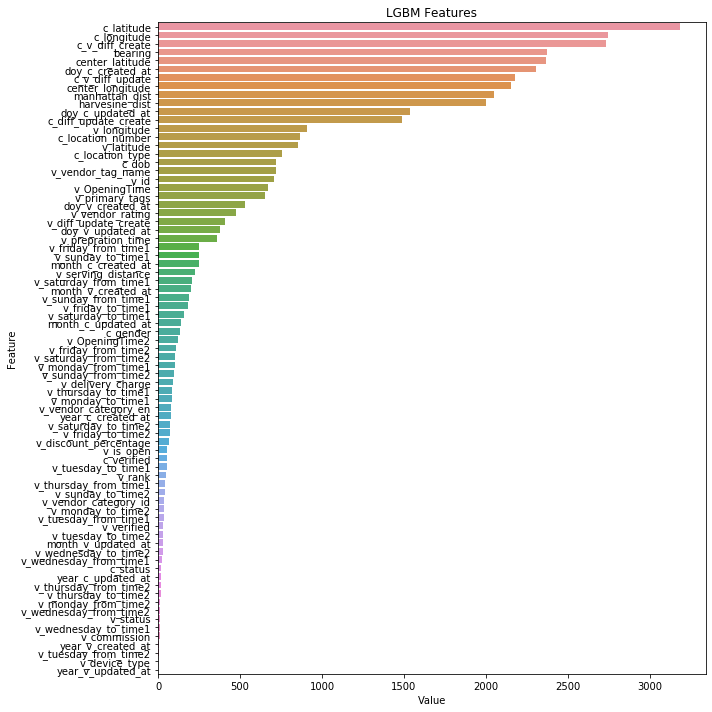

In [40]:
feature_imp = pd.DataFrame(sorted(zip(m.feature_importances_, train.columns), reverse=True)[:], columns=['Value','Feature'])
plt.figure(figsize=(10,10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LGBM Features')
plt.tight_layout()
plt.show()

# Model 2 Training on Complete Data 

In [42]:
int(1338*1.2)

1605

In [45]:
%%time
m = LGBMClassifier(n_estimators=1605,objective= "binary",metric= "auc",learning_rate=0.1,random_state=18121995,
                    scale_pos_weight=7.3,bagging_fraction=0.8,bagging_freq=1,feature_fraction=0.8, n_jobs=-1)
m.fit(train, y)
full_pred=m.predict(test)

Wall time: 27min 38s


In [46]:
final=pd.DataFrame()
final['CID X LOC_NUM X VENDOR']=test_id
final['target']=full_pred
final.target.value_counts()

0    1640722
1      31278
Name: target, dtype: int64

In [48]:
31278/1672000

0.01870693779904306

In [49]:
final.to_csv('V6_est_1605_feat77.csv',index=False)

### This is a very basic notebook. There are tons of things which can be tried with this data. 
### 1) Feature Engineering, I have done a very basic feature engineering.
### 2) You cannot directly use smote or adasyn here because data is large, but you can manipulate the original train and then use oversampling along with bagging or boosting. I am focussing on oversampling here beacuse undersampling has generally not helped me in competitions.
### 3) The main parameter to tune here was sample_pos_weight, so focus more on that if you use lightgbm and similarly for xgboost and class weight for Random Forest.
### 4) This notebook can serve as a good starting kit for the main hackathon.
### 5) Finally averaging the results using Stratified KFOLD etc..

#### These are just a few of the things, I had tons of ideas with this data. keep exploring more